# Session 4

## Minimum Number of Parameters Needed with State of Art Output

We used [Session 3](https://github.com/sambitdash/EVA-2/blob/master/Session-3/Session-3.ipynb) results to improve upon with total parameters. Reduction of the parameters to almost 1140 parameters gave sufficient confidence in reducing the session 3 parameters further while maintaining the accuracy within 99.75-99.82%.

Following are the suggested changes in achieving this:

1. A sequential model is chosen 
2. Two convolution layers are introduced with 16x3x3 kernel
3. Max Pool
4. 10x3x3 kernels are introduced associated with dropout of 0.1. 
5. Towards the end flattened and dense layer to map 3x2x2 to 10 levels

Overall parameters utilized are 7,063. Dropouts are added to ensure there is resilience built in the system. While without the dropouts the parameters can be reduced the resilience is important for the network to support inputs which is beyond the defined datasets.  

## Import Libraries and modules

In [2]:
import numpy as np

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Add
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import np_utils
from keras.datasets import mnist

Using TensorFlow backend.


## Load pre-shuffled MNIST data into train and test sets

- Training set contains - 60000 images mapping to categories of 0-9 numbers
- Test set contains - 10000 images

In [3]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

## Plot Image

Plot the first image in the series to understand the image data and get a feel for a sample. Handwritten number 5 is in the set. 

(60000, 28, 28)


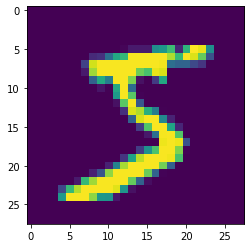

In [4]:
print (X_train.shape)
from matplotlib import pyplot as plt
%matplotlib inline
plt.imshow(X_train[0])

## Add Channel Information

The dataset does not have a channels layer as it's a grey scale image. The channel layer is needed for image manipulation and understanding later. So a single channel is extended as a 4th dimension. 

In [5]:
X_train = X_train.reshape(X_train.shape[0], 28, 28,1)
X_test = X_test.reshape(X_test.shape[0], 28, 28,1)

## Convert the Data to Float

The data is to be converted to float format for better computational resolutions. This also can be GPU dependent. Some GPUs may perform faster on fixed point or integral data type. Since the accuracy requirements higher in this problem one may prefer floats to gain better data resolution. 

In [6]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

## List Multiclass Data of the Dependent Variable

First 10 category outputs of the dependent variable in the training set. 

In [7]:
y_train[:10]

array([5, 0, 4, 1, 9, 2, 1, 3, 1, 4], dtype=uint8)

## Conversion to Categorical One Hot Vector Notation

Neural networks are best represented as 0 and 1 post final activation. Particularly, when softmax is used as the activation function. This notation makes it easier for modeling. 

In [8]:
# Convert 1-dimensional class arrays to 10-dimensional class matrices
Y_train = np_utils.to_categorical(y_train, 10)
Y_test = np_utils.to_categorical(y_test, 10)

## List One Hot Vector Notation of the Dependent Variable

First 10 category outputs of dependent variable in training set.

In [9]:
Y_train[:10]


array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]], dtype=float32)

## Improved Model

An improved model is proposed with a goal to show validation accuracy above 99.4%. A sequential Model is designed with:

1. Two 16x3x3 Convolutiion with ReLu Activation
2. MaxPool2D of 2x2 
3. Five 10x3x3 Convolutiion with ReLu Activation
4. Flatten the results 
5. One dense layer of 40 to 10 as the final outcome
6. Softmax activation to match the outcome to One Hot Vector notation

Overall 11,740 parameters

In [61]:
model = Sequential()
model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(28,28,1), name='c1'))
model.add(Conv2D(16, (3, 3), activation='relu', name='c2'))
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.1))
model.add(Conv2D(10, (3, 3), activation='relu', name='c3'))
model.add(Dropout(0.1))
model.add(Conv2D(10, (3, 3), activation='relu', name='c4'))
model.add(Dropout(0.1))
model.add(Conv2D(10, (3, 3), activation='relu', name='c5'))
model.add(Dropout(0.1))
model.add(Conv2D(10, (3, 3), activation='relu', name='c6'))
model.add(Conv2D(3, (3, 3), activation='relu', name='c7'))
model.add(Flatten())
model.add(Dense(10))
model.add(Activation('softmax'))
model.summary()
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
c1 (Conv2D)                  (None, 26, 26, 16)        160       
_________________________________________________________________
c2 (Conv2D)                  (None, 24, 24, 16)        2320      
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 12, 12, 16)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 12, 12, 16)        0         
_________________________________________________________________
c3 (Conv2D)                  (None, 10, 10, 10)        1450      
_________________________________________________________________
dropout_10 (Dropout)         (None, 10, 10, 10)        0         
_________________________________________________________________
c4 (Conv2D)                  (None, 8, 8, 10)          910       
__________

## Training Process

While most of the model part is fairly kept standard with CNN with a combination of convolutions and maxpooling the training approach is enhanced with an ensemble technique called stratfied K-fold. 

The training for a neural network can be improved when optimal statistical mixing can be carried out for the input for a homogenized mix of batches. This is achieved by stratified k-fold. Here the training data is broken into disjoint sets of 5 with almost equal sample occurence of any of the classes of 0-9 in each of the groups. 4 such groups are used as a training set and validated against one of the set as validation set. Thus the results are cross validated against each other. This ensures the batches are homogeneous and uniformly exposed to the each category of the inputs. Each such groups is run for 10 epochs but parameters being fed from the previous run. 

Moreover, in every epoch the validation rsults are computed with the original test dataset of 10000 data points.


The technique has been a small modification of explanation given in the [article](https://machinelearningmastery.com/evaluate-performance-deep-learning-models-keras/)

In [62]:
from sklearn.model_selection import StratifiedKFold
seed = 7
np.random.seed(seed)
# define 10-fold cross validation test harness
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
cvscores = []
(X, Y) = (X_train, y_train)
(init_epoch, nepoch) = (0, 10)
for train, test in kfold.split(X, Y):
    # Fit the model
    model.fit(X[train], Y_train[train], epochs=init_epoch+nepoch, initial_epoch=init_epoch, batch_size=32, verbose=1, validation_data=(X_test, Y_test))
    init_epoch += nepoch
    
    # evaluate the model
    scores = model.evaluate(X[test], Y_train[test], verbose=0)
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1] * 100)

Train on 47995 samples, validate on 10000 samples
Epoch 1/10
47995/47995 [==============================] - 13s 274us/step - loss: 0.1516 - acc: 0.9485 - val_loss: 0.0539 - val_acc: 0.9831
Epoch 2/10
47995/47995 [==============================] - 11s 233us/step - loss: 0.0574 - acc: 0.9813 - val_loss: 0.0326 - val_acc: 0.9895
Epoch 3/10
47995/47995 [==============================] - 11s 231us/step - loss: 0.0421 - acc: 0.9862 - val_loss: 0.0257 - val_acc: 0.9920
Epoch 4/10
47995/47995 [==============================] - 11s 232us/step - loss: 0.0346 - acc: 0.9888 - val_loss: 0.0245 - val_acc: 0.9918
Epoch 5/10
47995/47995 [==============================] - 11s 232us/step - loss: 0.0302 - acc: 0.9903 - val_loss: 0.0181 - val_acc: 0.9943
Epoch 6/10
47995/47995 [==============================] - 11s 234us/step - loss: 0.0272 - acc: 0.9913 - val_loss: 0.0166 - val_acc: 0.9948
Epoch 7/10
47995/47995 [==============================] - 11s 232us/step - loss: 0.0252 - acc: 0.9919 - val_loss: 0.

## Results

The final cross validation score is averaged over each of the iterations are stated. As expected, the cross validation being on the training data there is a continuous pattern of overfitting of the data. However, what is interesting to observe the validation score over the test data has also significantly improved at 99.80%. 

Now that the test data is not used for any of the training purposes, the result cannot be construed as overfitting. Although, the learning curve has not been plotted to confirm the same. The crossvalidation results are not significantly different from the test data validation confirming the training is fairly uniform for the overall population. 

The state of art is reported as: https://paperswithcode.com/sota/image-classification-on-mnist with https://paperswithcode.com/paper/rmdl-random-multimodel-deep-learning-for using a random combination of DNN, CNN, and RNN, a simple statistical mixing of training data can almost produce similar outcome with the MNIST dataset.

In [63]:
cvscores

[99.54685493987185,
 99.63506027333558,
 99.71166605949402,
 99.74993698108273,
 99.78075981458134]

In [64]:
score = model.evaluate(X_test, Y_test, verbose=0)

In [65]:
print(score)

[0.007393474755669012, 0.9979499967575073]


In [66]:
y_pred = model.predict(X_test)
np.set_printoptions(precision=1, suppress=True)
print(y_pred[:10])
print(y_test[:10])

[[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
[7 2 1 0 4 1 4 9 5 9]


In [71]:
layer_dict = dict([(layer.name, layer) for layer in model.layers])

import numpy as np
from matplotlib import pyplot as plt
from keras import backend as K
%matplotlib inline
# util function to convert a tensor into a valid image
def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    #x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x

def vis_img_in_filter(img = np.array(X_train[2]).reshape((1, 28, 28, 1)).astype(np.float64), 
                      layer_name = 'c1'):
    layer_output = layer_dict[layer_name].output
    img_ascs = list()
    for filter_index in range(layer_output.shape[3]):
        # build a loss function that maximizes the activation
        # of the nth filter of the layer considered
        loss = K.mean(layer_output[:, :, :, filter_index])

        # compute the gradient of the input picture wrt this loss
        grads = K.gradients(loss, model.input)[0]

        # normalization trick: we normalize the gradient
        grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

        # this function returns the loss and grads given the input picture
        iterate = K.function([model.input], [loss, grads])

        # step size for gradient ascent
        step = 5.

        img_asc = np.array(img)
        # run gradient ascent for 20 steps
        for i in range(20):
            loss_value, grads_value = iterate([img_asc])
            img_asc += grads_value * step

        img_asc = img_asc[0]
        img_ascs.append(deprocess_image(img_asc).reshape((28, 28)))
        
    nfig = int(layer_output.shape[3])

    if nfig >= 35:
        plot_x, plot_y = 7, 6
    elif nfig >= 29:
        plot_x, plot_y = 6, 6
    elif nfig >= 23:
        plot_x, plot_y = 5, 6
    elif nfig >= 17:
        plot_x, plot_y = 4, 6
    elif nfig >= 11:
        plot_x, plot_y = 3, 6
    else:
        plot_x, plot_y = 1, nfig+1
    
    fig, ax = plt.subplots(plot_x, plot_y, figsize = (12, 12))
    if plot_x > 1:
        ax[0, 0].imshow(img.reshape((28, 28)), cmap = 'gray')
        ax[0, 0].set_title('Input image')
    else:
        ax[0].imshow(img.reshape((28, 28)), cmap = 'gray')
        ax[0].set_title('Input image')    
    for (x, y) in [(i, j) for i in range(plot_x) for j in range(plot_y)]:
        if x == 0 and y == 0:
            continue
        if x * plot_y + y > nfig:
            break
        if plot_x > 1:
            ax[x, y].imshow(img_ascs[x * plot_y + y - 1], cmap = 'gray')
            ax[x, y].set_title('filter %d' % (x * plot_y + y - 1))
        else:
            ax[y].imshow(img_ascs[x * plot_y + y - 1], cmap = 'gray')
            ax[y].set_title('filter %d' % (x * plot_y + y - 1))

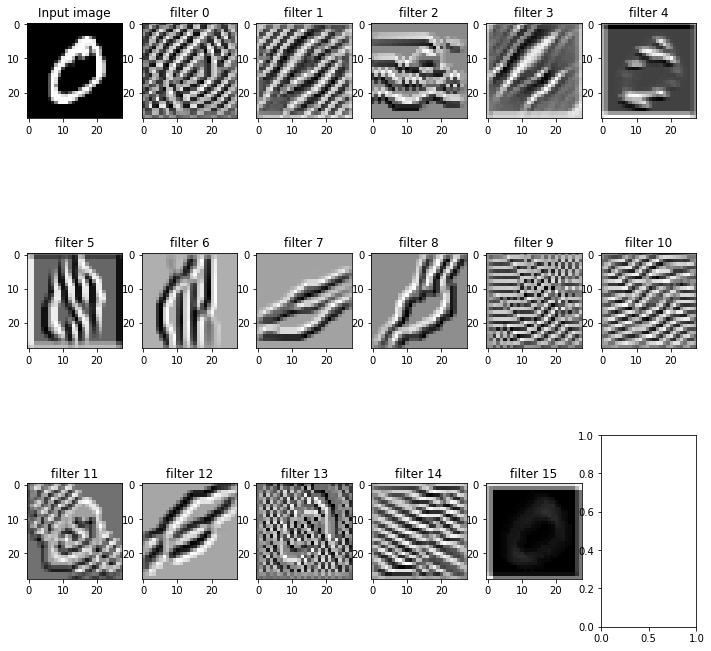

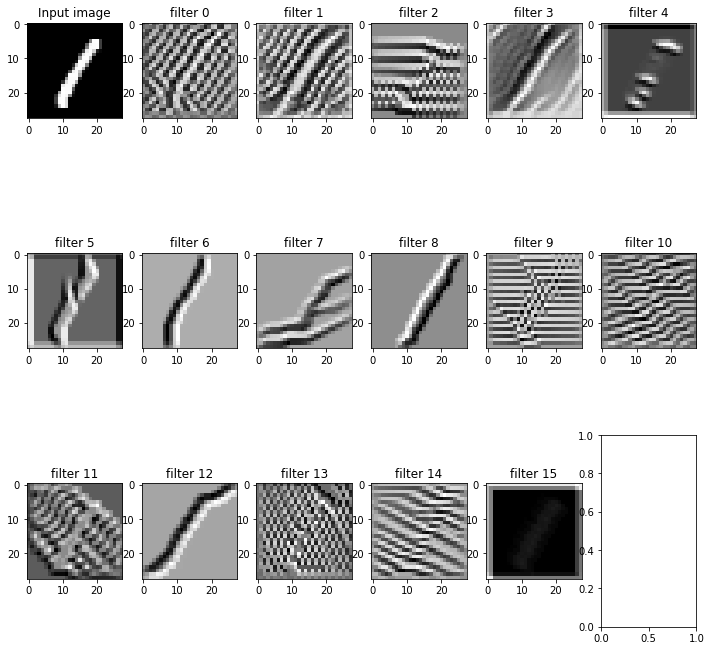

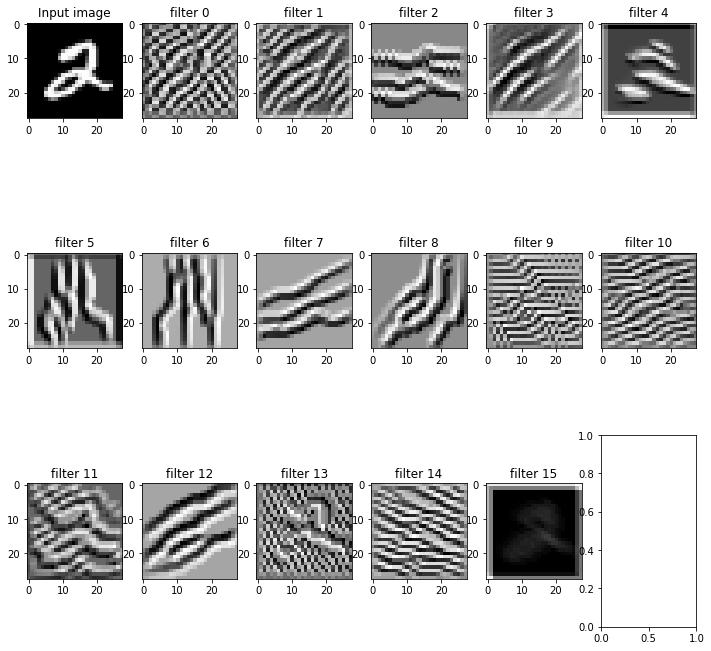

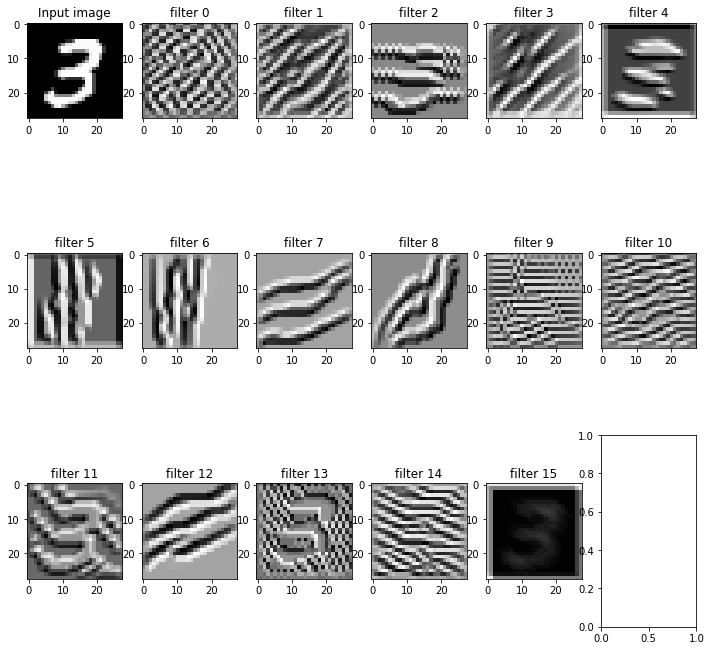

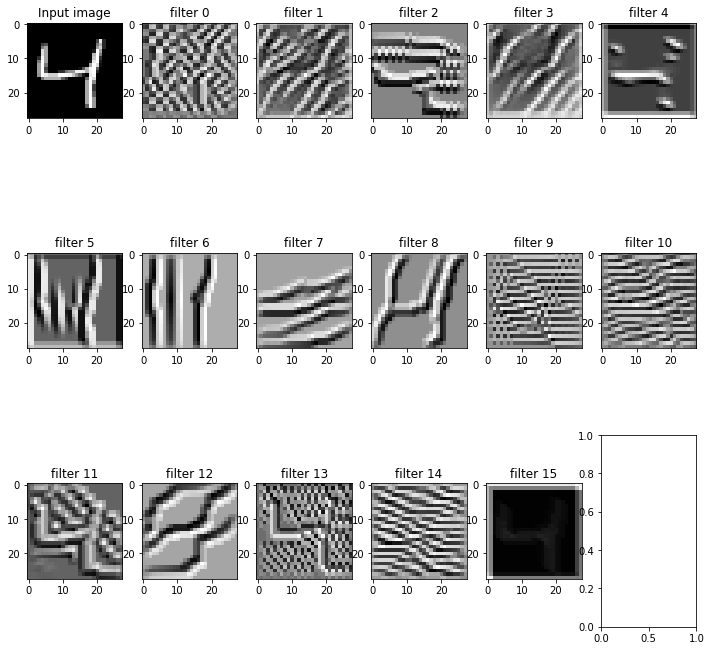

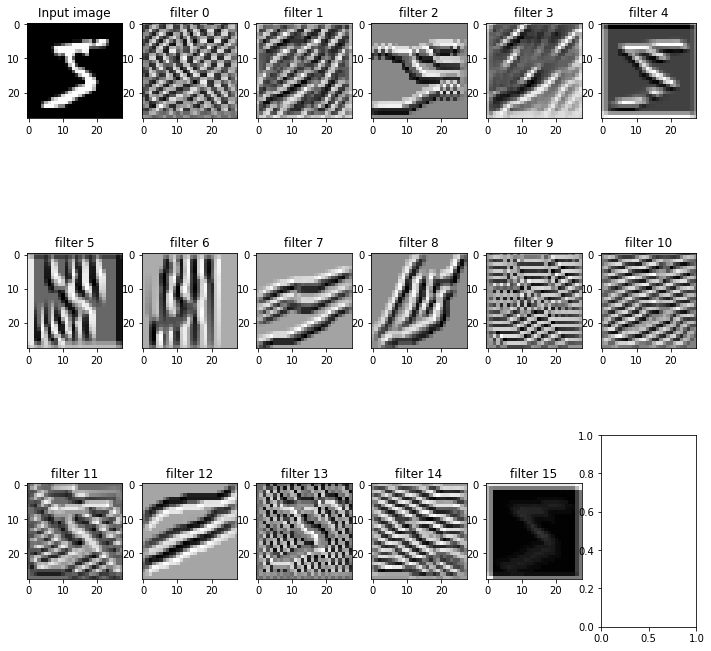

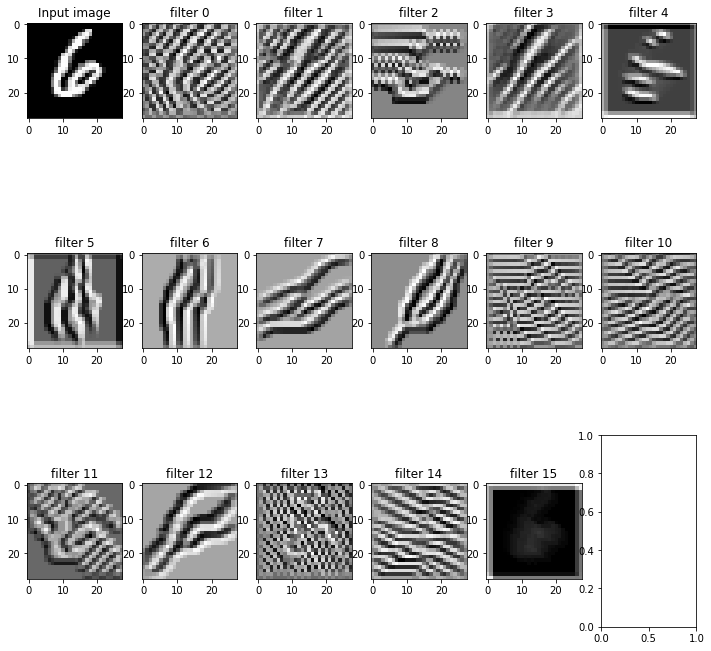

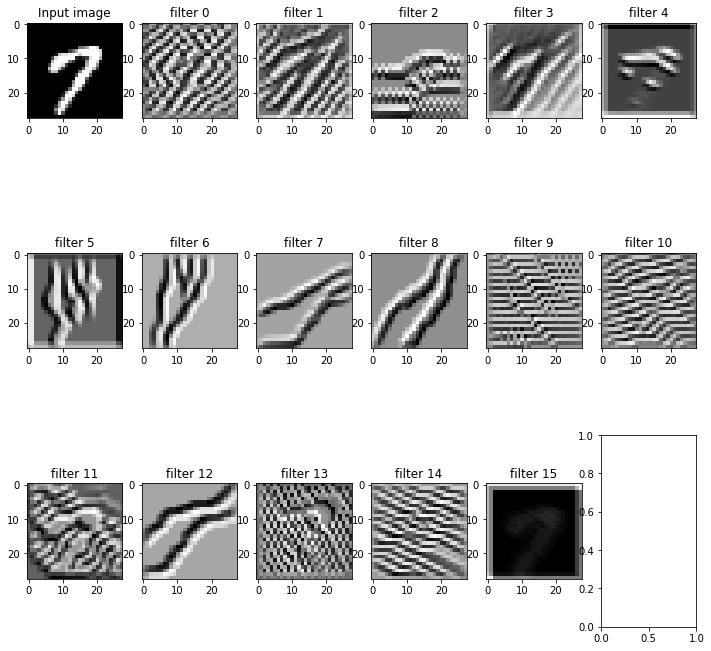

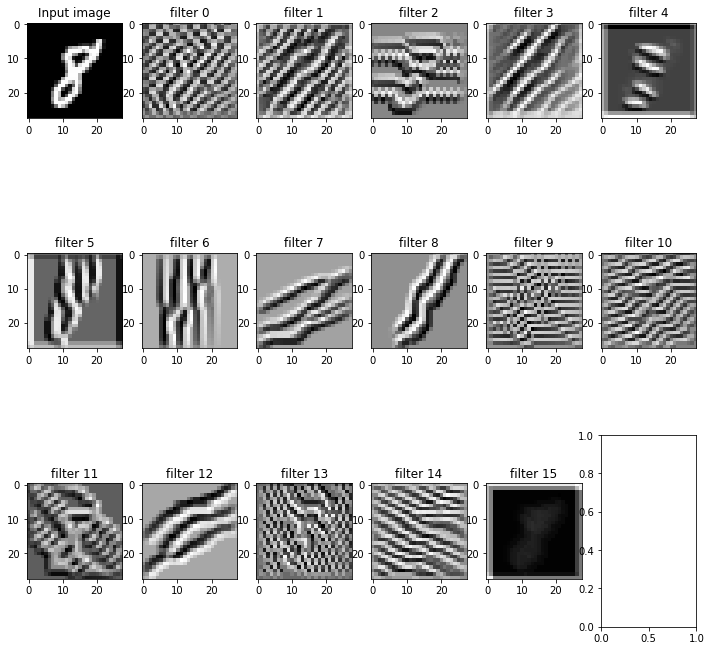

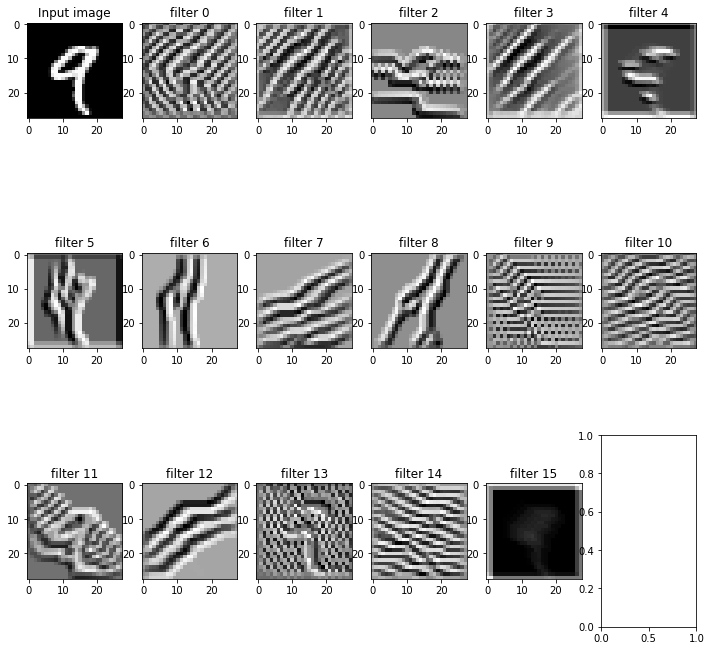

In [72]:
ln = 'c1'
vis_img_in_filter(img = np.array(X_train[1]).reshape((1, 28, 28, 1)).astype(np.float64),  layer_name = ln)
vis_img_in_filter(img = np.array(X_train[3]).reshape((1, 28, 28, 1)).astype(np.float64),  layer_name = ln)
vis_img_in_filter(img = np.array(X_train[5]).reshape((1, 28, 28, 1)).astype(np.float64),  layer_name = ln)
vis_img_in_filter(img = np.array(X_train[7]).reshape((1, 28, 28, 1)).astype(np.float64),  layer_name = ln)
vis_img_in_filter(img = np.array(X_train[2]).reshape((1, 28, 28, 1)).astype(np.float64),  layer_name = ln)
vis_img_in_filter(img = np.array(X_train[0]).reshape((1, 28, 28, 1)).astype(np.float64),  layer_name = ln)
vis_img_in_filter(img = np.array(X_train[13]).reshape((1, 28, 28, 1)).astype(np.float64),  layer_name = ln)
vis_img_in_filter(img = np.array(X_train[15]).reshape((1, 28, 28, 1)).astype(np.float64),  layer_name = ln)
vis_img_in_filter(img = np.array(X_train[17]).reshape((1, 28, 28, 1)).astype(np.float64),  layer_name = ln)
vis_img_in_filter(img = np.array(X_train[4]).reshape((1, 28, 28, 1)).astype(np.float64),  layer_name = ln)